## Lab 1.3 - Predicting Real Estate Data in St. Petersburg
We have data from Yandex.Realty classified https://realty.yandex.ru containing real estate listings for apartments in St. Petersburg and Leningrad Oblast from 2016 till the middle of August 2018. In this Lab you'll learn how to apply machine learning algorithms to solve business problems. Accurate price prediction can help to find fraudsters automatically and help Yandex.Realty users to make better decisions when buying and selling real estate.

Using python with machine learning algotithms is the #1 option for prototyping solutions among data scientists today. We'll take a look at it in this lab.

### Main objectives
After successful completion of the lab work students will be able to:
-	Apply machine learning for solving price prediction problem
-   Calculate metrics which can help us find out whether our machine learning model is ready for production

### Tasks
-	Encode dataset
-	Split dataset to train and validation datasets
-	Apply decision tree algorithm to build ML (machine learning) model for price predictions
-   Calculate metrics
-   Try other algorithms and factors to get a better solution 


### 1. Load data with real estate prices

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.style as style
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_percentage_error as mape

import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
style.use('fivethirtyeight')

In [49]:
rent_df_cleaned = pd.read_csv('cleaned_dataset.tsv', on_bad_lines='skip', sep='\t')

In [50]:
rent_df_cleaned.head()

,offer_id,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,renovation,offer_type,unified_address,building_id,price_per_sq_m,house_price_sqm_median
0,1100202,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,20000.0,7,0,1,0,28.0,8.0,20.0,3.0,2,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,714.285714,512.820513
1,4593125,2015-11-17T00:00:00+03:00,2016-03-04T00:00:00+03:00,24000.0,4,0,2,0,59.0,10.0,35.0,3.0,2,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,406.779661,512.820513
2,4586184,2015-11-17T00:00:00+03:00,2016-04-24T00:00:00+03:00,18000.0,6,0,1,0,36.0,9.0,17.0,3.0,2,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,500.000000,512.820513
3,5308071,2016-02-04T00:00:00+03:00,2016-02-28T00:00:00+03:00,18000.0,8,0,1,0,39.0,10.0,18.0,0.0,2,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,461.538462,512.820513
4,7534283612538021121,2016-02-28T00:00:00+03:00,2016-04-02T00:00:00+03:00,19000.0,3,0,1,0,36.0,8.0,18.0,11.0,2,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,527.777778,512.820513


In [51]:
rent_df_cleaned = rent_df_cleaned[['first_day_exposition', 
                                   'last_day_exposition', 
                                   'area', 'living_area', 
                                   'last_price', 'open_plan', 
                                   'rooms', 
                                   'renovation',
                                   'house_price_sqm_median']]

In [52]:
#rent_df_cleaned['log_last_price'] = np.log(rent_df_cleaned['last_price'])

In [53]:
rent_df_cleaned.tail(3)

,first_day_exposition,last_day_exposition,area,living_area,last_price,open_plan,rooms,renovation,house_price_sqm_median
155497,2018-08-20T00:00:00+03:00,2018-08-20T00:00:00+03:00,67.0,NaN,30000.0,0,2,NaN,447.761194
155498,2018-08-20T00:00:00+03:00,2018-08-20T00:00:00+03:00,56.0,32.0,50000.0,0,2,NaN,892.857143
155499,2017-09-12T00:00:00+03:00,2018-08-20T00:00:00+03:00,46.0,25.0,55000.0,0,2,11.0,1195.652174


In [54]:
rent_df_cleaned.describe()

,area,living_area,last_price,open_plan,rooms,renovation,house_price_sqm_median
count,155500.000000,123106.000000,155500.000000,155500.000000,155500.000000,102751.000000,155500.000000
mean,53.388608,30.423321,31879.141505,0.000051,1.600071,3.696937,588.502449
std,24.134163,17.410504,20301.276025,0.007172,0.873182,4.489422,151.986949
min,11.000000,2.000000,130.000000,0.000000,0.000000,0.000000,76.923077
25%,38.000000,18.000000,20000.000000,0.000000,1.000000,0.000000,500.000000
50%,46.000000,27.000000,25000.000000,0.000000,1.000000,1.000000,552.631579
75%,62.000000,37.000000,35000.000000,0.000000,2.000000,10.000000,640.476190
max,200.000000,2015.000000,199000.000000,1.000000,5.000000,11.000000,2467.532468


### 2. Data Transformation

In [55]:
(rent_df_cleaned.isna().sum() / len(rent_df_cleaned)).rename('percent of NA').to_frame().style.bar(vmax=1, vmin=0).format('{:.2%}')

,percent of NA
first_day_exposition,0.00%
last_day_exposition,0.00%
area,0.00%
living_area,20.83%
last_price,0.00%
open_plan,0.00%
rooms,0.00%
renovation,33.92%
house_price_sqm_median,0.00%


In [56]:
rent_df_cleaned.renovation.value_counts()

0.0     50225
3.0     16422
11.0    14088
10.0    13885
7.0      3885
1.0      3126
6.0       699
8.0       226
2.0       162
4.0        32
5.0         1
Name: renovation, dtype: int64

<AxesSubplot: >

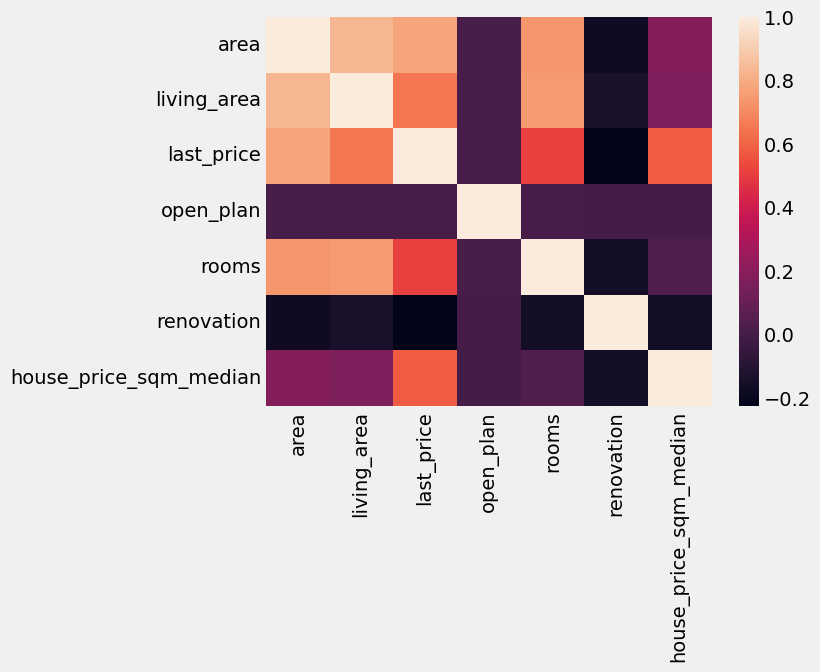

In [57]:
sns.heatmap(rent_df_cleaned.corr())

In [58]:
median_living_area = rent_df_cleaned.groupby('area')['living_area'].median()

rent_df_cleaned['living_area'] = rent_df_cleaned.apply(
    lambda row: median_living_area[row['area']] if np.isnan(row['living_area']) else row['living_area'],
    axis=1
)

In [59]:
(rent_df_cleaned.isna().sum() / len(rent_df_cleaned)).rename('percent of NA').to_frame().style.bar(vmax=1, vmin=0).format('{:.2%}')

,percent of NA
first_day_exposition,0.00%
last_day_exposition,0.00%
area,0.00%
living_area,0.03%
last_price,0.00%
open_plan,0.00%
rooms,0.00%
renovation,33.92%
house_price_sqm_median,0.00%


In [60]:
rent_df_cleaned.groupby('renovation')['renovation'].count()

renovation
0.0     50225
1.0      3126
2.0       162
3.0     16422
4.0        32
5.0         1
6.0       699
7.0      3885
8.0       226
10.0    13885
11.0    14088
Name: renovation, dtype: int64

In [63]:
# rent_df_cleaned.drop(columns='renovation', inplace=True)

rent_df_cleaned = rent_df_cleaned.dropna(subset=['living_area'])
rent_df_cleaned = rent_df_cleaned.dropna(subset=['renovation'])

In [64]:
(rent_df_cleaned.isna().sum() / len(rent_df_cleaned)).rename('percent of NA').to_frame().style.bar(vmax=1, vmin=0).format('{:.2%}')

,percent of NA
first_day_exposition,0.00%
last_day_exposition,0.00%
area,0.00%
living_area,0.00%
last_price,0.00%
open_plan,0.00%
rooms,0.00%
renovation,0.00%
house_price_sqm_median,0.00%


In [65]:
rent_df_cleaned.first_day_exposition = pd.to_datetime(rent_df_cleaned.first_day_exposition)
rent_df_cleaned.last_day_exposition = pd.to_datetime(rent_df_cleaned.last_day_exposition)

In [66]:
rent_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102731 entries, 0 to 155499
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype                                
---  ------                  --------------   -----                                
 0   first_day_exposition    102731 non-null  datetime64[ns, pytz.FixedOffset(180)]
 1   last_day_exposition     102731 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   area                    102731 non-null  float64                              
 3   living_area             102731 non-null  float64                              
 4   last_price              102731 non-null  float64                              
 5   open_plan               102731 non-null  int64                                
 6   rooms                   102731 non-null  int64                                
 7   renovation              102731 non-null  float64                              
 8   house_price_sqm_median  102731 non-null  floa

In [67]:
rent_df_cleaned['days_published'] = (rent_df_cleaned['last_day_exposition'] - rent_df_cleaned['first_day_exposition']).dt.days

In [68]:
rent_df_cleaned.head()

,first_day_exposition,last_day_exposition,area,living_area,last_price,open_plan,rooms,renovation,house_price_sqm_median,days_published
0,2015-01-24 00:00:00+03:00,2016-01-19 00:00:00+03:00,28.0,20.0,20000.0,0,1,3.0,512.820513,360
1,2015-11-17 00:00:00+03:00,2016-03-04 00:00:00+03:00,59.0,35.0,24000.0,0,2,3.0,512.820513,108
2,2015-11-17 00:00:00+03:00,2016-04-24 00:00:00+03:00,36.0,17.0,18000.0,0,1,3.0,512.820513,159
3,2016-02-04 00:00:00+03:00,2016-02-28 00:00:00+03:00,39.0,18.0,18000.0,0,1,0.0,512.820513,24
4,2016-02-28 00:00:00+03:00,2016-04-02 00:00:00+03:00,36.0,18.0,19000.0,0,1,11.0,512.820513,34


In [69]:
#renovation_encoded = pd.get_dummies(rent_df_cleaned, columns=['renovation','open_plan','rooms'])

In [70]:
#renovation_encoded.head(3)

In [71]:
rent_df_cleaned.drop(columns=['first_day_exposition','last_day_exposition'], inplace=True)

In [74]:
rent_df_cleaned.tail(3)

,area,living_area,last_price,open_plan,rooms,renovation,days_published
155489,38.5,19.0,20000.0,0,1,3.0,1
155493,34.0,18.0,17000.0,0,1,3.0,0
155499,46.0,25.0,55000.0,0,2,11.0,342


In [77]:
rent_df_cleaned.drop(columns=['house_price_sqm_median'], inplace=True)

KeyError: "['house_price_sqm_median'] not found in axis"

In [78]:
X = rent_df_cleaned.drop('last_price', axis=1)
y = rent_df_cleaned['last_price']

In [79]:
# numerical_features = ['area', 'living_area', 'house_price_sqm_median', 'days_published']

# scaler = StandardScaler()
# 
# X[numerical_features] = scaler.fit_transform(X[numerical_features])
# y = scaler.fit_transform(y.values.reshape(-1, 1))
# 

In [80]:
# Code from Nikitin

# from sklearn.preprocessing import StandardScaler
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# 
# X_train = sc_X.fit_transform(X_train)
# X_valid = sc_X.fit_transform(X_valid)
# y_train = sc_y.fit_transform(y_train)
# y_valid = sc_y.fit_transform(y_valid)

### 3. Models

In [81]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=7)

In [82]:
# numerical_features_X = ['area', 'living_area', 'house_price_sqm_median', 'days_published', 'open_plan', 'rooms']
# 
# scaler_X = StandardScaler()
# scaler_y = StandardScaler()
# 
# 
# X_train[numerical_features_X] = scaler_X.fit_transform(X_train[numerical_features_X])
# X_valid[numerical_features_X] = scaler_X.fit_transform(X_valid[numerical_features_X])
# 
# # Convert y_train to numpy array if it's not already
# y_train = np.array(y_train).reshape(-1, 1)
# y_valid = np.array(y_valid).reshape(-1, 1)
# 
# y_train = scaler_y.fit_transform(y_train)
# y_valid = scaler_y.fit_transform(y_valid)

In [83]:
print(X_train)

        area  living_area  open_plan  rooms  renovation  days_published
9679    38.0         18.0          0      1        10.0               6
104384  44.0         28.0          0      2         7.0               3
27279   80.0         51.0          0      3         0.0               6
40227   95.0         50.0          0      2         0.0              24
17341   52.0         42.0          0      2        11.0              13
...      ...          ...        ...    ...         ...             ...
77308   58.0         34.0          0      2         0.0              11
15758   72.0         36.0          0      2         0.0             162
71834   55.0         36.0          0      2         0.0               7
84651   35.0         18.0          0      1         0.0               3
89124   60.0         45.0          0      1         0.0              16

[77048 rows x 6 columns]


In [84]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()


X_train = scaler_X.fit_transform(X_train)
X_valid = scaler_X.fit_transform(X_valid)

# Convert y_train to numpy array if it's not already
y_train = np.array(y_train).reshape(-1, 1)
y_valid = np.array(y_valid).reshape(-1, 1)

y_train = scaler_y.fit_transform(y_train)
y_valid = scaler_y.fit_transform(y_valid)

In [85]:
print(X_train)

[[-0.66381037 -0.69281429 -0.00882494 -0.78728333  1.40294535 -0.49975561]
 [-0.41755114 -0.14032692 -0.00882494  0.37943025  0.73533221 -0.51533539]
 [ 1.06000422  1.13039405 -0.00882494  1.54614384 -0.82243178 -0.49975561]
 ...
 [ 0.03392411  0.30166299 -0.00882494  0.37943025 -0.82243178 -0.49456235]
 [-0.78693998 -0.69281429 -0.00882494 -0.78728333 -0.82243178 -0.51533539]
 [ 0.23914013  0.79890163 -0.00882494 -0.78728333 -0.82243178 -0.44782303]]


In [86]:
X_train.shape, y_train.shape

((77048, 6), (77048, 1))

In [87]:
# from sklearn.preprocessing import StandardScaler
# 
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# 
# # Fit and transform X data
# X_train = sc_X.fit_transform(X_train)
# X_valid = sc_X.transform(X_valid)  # Use transform instead of fit_transform for validation set
# 
# # Reshape y data to be 2D
# y_train = y_train.values.reshape(-1, 1)
# y_valid = y_valid.values.reshape(-1, 1)
# 
# # Fit and transform y data
# y_train = sc_y.fit_transform(y_train)
# y_valid = sc_y.transform(y_valid)  # Use transform instead of fit_transform for validation set

#### Selection and Evaluation

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=7),
    'Random Forest': RandomForestRegressor(random_state=7),
    'XGBoost': XGBRegressor(random_state=7)
}

# Evaluate models with default hyperparameters
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred)
    mae = mean_absolute_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)
    print(f'{name} Mean Squared Error: {mse}')
    print(f'{name} Mean Absolute Error: {mae}')
    print(f'{name} R-squared: {r2}\n')
    print()


Linear Regression Mean Squared Error: 0.3655400040729951
Linear Regression Mean Absolute Error: 0.38187130904877015
Linear Regression R-squared: 0.634459995927005


Decision Tree Mean Squared Error: 0.6887241818693642
Decision Tree Mean Absolute Error: 0.49752521580421044
Decision Tree R-squared: 0.31127581813063576


Random Forest Mean Squared Error: 0.39147352013268977
Random Forest Mean Absolute Error: 0.38025634660364804
Random Forest R-squared: 0.6085264798673102


XGBoost Mean Squared Error: 0.35681822830172866
XGBoost Mean Absolute Error: 0.34777126464898345
XGBoost R-squared: 0.6431817716982713




| Model             | Mean Squared Error (MSE) | Mean Absolute Error (MAE) | R-squared (R²) |
|-------------------|--------------------------|---------------------------|----------------|
| Linear Regression | 0.1980                   | 0.2692                    | 0.8007         |
| Decision Tree     | 0.2895                   | 0.3122                    | 0.7087         |
| Random Forest     | 0.1557                   | 0.2307                    | 0.8434         |
| XGBoost           | 0.1557                   | 0.2260                    | 0.8433         |


* `Random Forest` and `XGBoost` models show the lowest MSE and highest R², indicating they provide the best predictive performance and explain the most variance in the target variable (last_price).

__`XGBoost`__ model will be used as a ML predictor of prices.

#### Tuning Model [RandomizedSearchCV]

In [89]:
from scipy.stats import uniform

param_dist_xgb = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': uniform(0.01, 0.3),  # Uniform distribution between 0.01 and 0.31
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': uniform(0.6, 0.4),       # Uniform distribution between 0.6 and 1.0
    'colsample_bytree': uniform(0.6, 0.4) # Uniform distribution between 0.6 and 1.0
}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=7)

# Initialize RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, 
                                       param_distributions=param_dist_xgb, 
                                       n_iter=100, 
                                       cv=3, 
                                       scoring='neg_mean_squared_error', 
                                       n_jobs=-1, 
                                       random_state=7)

random_search_xgb.fit(X_train, y_train)

best_xgb = random_search_xgb.best_estimator_
print(f'Best XGBoost parameters: {best_xgb}')

In [ ]:
import matplotlib.pyplot as plt


# Plot feature importance
xgb.plot_importance(best_xgb, importance_type='weight')
plt.show()

What we see here is basically what features inluence the target variable the most: 
1. `area`, obviously, is the main condition to determine the price
2. price of the sqm in the house also may help to indicate the location o the apartment in the city (closer to the center, more expensive it gets)
3. living area is another regressor helping to understand, well, the living area (there also might be closets, balconies, etc.)
4. days published and rooms has the least inluence

In [ ]:
xgb_model = XGBRegressor(**random_search_xgb.best_params_, random_state=7)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_valid)

# Evaluate the model
mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f'XGBoost Mean Squared Error: {mse}')
print(f'XGBoost Mean Absolute Error: {mae}')
print(f'XGBoost R-squared: {r2}')

---
The tuning slightly improved the model and evaluation metrics.

In [ ]:
from sklearn.model_selection import cross_val_score

# Function to scale the y data within cross-validation
def scale_y_within_cv(estimator, X, y):
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()
    return cross_val_score(estimator, X, y_scaled, cv=5, scoring='neg_mean_squared_error')

# Perform cross-validation
cv_scores = scale_y_within_cv(xgb_model, X, y.values)
cv_mse_scores = -cv_scores  # Convert scores back to positive MSE values

print(f'Cross-Validation Mean Squared Error: {cv_mse_scores.mean()}')


In [ ]:
from sklearn.model_selection import learning_curve

# Use learning_curve to get train_sizes, train_scores, and test_scores
train_sizes, train_scores, test_scores = learning_curve(xgb_model, 
                                                        X_train, 
                                                        y_train, 
                                                        cv=3, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curves (XGBoost)")
plt.legend(loc="best")
plt.grid()
plt.show()


**Our model performs well is is not neither overfitted nor underfitted, amazing!**

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(scaler_y.inverse_transform(y_valid.reshape(-1, 1)), label='Valid', color='blue')
plt.plot(scaler_y.inverse_transform(y_pred.reshape(-1, 1)), label='Predict', color='orange')
plt.legend()
plt.show()

In [ ]:
import joblib

model_file = 'model.pkl'
joblib.dump(xgb_model, model_file)

scaler_X_file = 'scaler_x.pkl'
joblib.dump(scaler_X, scaler_X_file)

scaler_y_file = 'scaler_y.pkl'
joblib.dump(scaler_y, scaler_y_file)


In [ ]:
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_valid)

# Reshape the predictions to a 2D array
y_pred_reshaped = y_pred.reshape(-1, 1)

# Inverse transform the scaled predictions to get them back to the original scale
predictions = scaler_y.inverse_transform(y_pred_reshaped)

# Reshape y_valid to a 2D array if it isn't already
if y_valid.ndim == 1:
    y_valid_reshaped = y_valid.reshape(-1, 1)
else:
    y_valid_reshaped = y_valid

# Inverse transform the true values to get them back to the original scale
true_values = scaler_y.inverse_transform(y_valid_reshaped)

# Display the first 5 predictions and true values
for pred, val in zip(predictions[5:30], true_values[5:30]):
    print(f"Prediction: {pred[0]}, True Value: {val[0]}")


In [ ]:
pwd

In [ ]:
import numpy as np
import pickle
import ipywidgets as widgets
from IPython.display import display
from sklearn.preprocessing import StandardScaler

# Load the trained model and scalers with error handling
try:
    with open('model.pkl', 'rb') as model_file, open('scaler_x.pkl', 'rb') as sc_x_file, open('scaler_y.pkl', 'rb') as sc_y_file:
        model = pickle.load(model_file)
        sc_x = pickle.load(sc_x_file)
        sc_y = pickle.load(sc_y_file)
except pickle.UnpicklingError as e:
    print(f"Error unpickling file: {e}")
except FileNotFoundError as e:
    print(f"File not found: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

def predict(open_plan, house_price_sqm_median, lving_area, rooms, area, days_published):
    x = np.array([open_plan, rooms, area, house_price_sqm_median, lving_area, days_published]).reshape(1, -1)
    x = sc_x.transform(x)
    result = model.predict(x)
    result = sc_y.inverse_transform(result.reshape(1, -1))
    return str(result[0][0])

# Create input widgets
open_plan_widget = widgets.IntText(description='Open Plan:')
house_price_sqm_median_widget = widgets.FloatText(description='House Price/sqm:')
lving_area_widget = widgets.FloatText(description='Living Area:')
rooms_widget = widgets.IntText(description='Rooms:')
area_widget = widgets.FloatText(description='Area:')
days_published_widget = widgets.IntText(description='Days Published:')
output = widgets.Output()

def on_button_click(b):
    with output:
        output.clear_output()
        result = predict(
            open_plan_widget.value,
            house_price_sqm_median_widget.value,
            lving_area_widget.value,
            rooms_widget.value,
            area_widget.value,
            days_published_widget.value
        )
        print(f"Predicted Result: {result}")

button = widgets.Button(description="Predict")
button.on_click(on_button_click)

# Display widgets
display(open_plan_widget, house_price_sqm_median_widget, lving_area_widget, rooms_widget, area_widget, days_published_widget, button, output)
